In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as pltp
import tensorflow as tf
import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

In [2]:
#Función que separa los parametros t,g,v del fileName
def separateParams(fileName):
    t = fileName.split("t")[1].split("g")[0]
    rest_of = fileName.split("t")[1].split("g")[1].split("v")
    g, v = rest_of
    return float(t), float(g)/10, float(v)

In [3]:
#Se definen los sets de training, test y validación
def train_val_test_split(X, y, train_size, val_size, test_size, random_state = 1):
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None 
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = val_size/(test_size + train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
files = glob.glob('../data-lineas-espectrales/filtered_wv_models/*')
file_qty = len(files)
print("Files qty: {}".format(file_qty))

Files qty: 5425


In [5]:
y = np.zeros((file_qty,3))
df = pd.read_csv(files[0], sep=" ", header=None)
n_points , n_columns = df.shape
print("points: {} | columns: {} ".format(n_points, n_columns))

points: 201 | columns: 2 


In [6]:
#Matriz que contiene las lineas espectrales
X = np.zeros((file_qty, n_points))
#Matriz que contiene los labels de cada linea espectral
y = np.zeros((file_qty, 3))

print(X.shape)
print(y.shape)

(5425, 201)
(5425, 3)


In [7]:
#extract files, se almacenan las lineas espectrales y labels en X e y respectivamente
for i, name in enumerate(files):
    file_name = name.split("/")[-1].split(".")[0].split("_")[1]
    df = pd.read_csv(name, sep=" ", header=None)
    t, g, v = separateParams(file_name)
    #Se almacena la línea espectral
    X[i, :] = df[1].values
    #Se almacena el label de la linea espectral
    y[i] = t, g, v

In [8]:
print(y[:4])

[[3.5e+04 2.0e+00 2.8e+02]
 [2.0e+04 2.0e+00 2.6e+02]
 [2.8e+04 2.0e+00 3.5e+02]
 [1.7e+04 3.0e+00 1.7e+02]]


In [9]:
#se normaliza y
standardScaler = StandardScaler()
standardScaler.fit(y)
normalized_y = standardScaler.transform(y)

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, normalized_y, .8, .1, .1)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4339, 201) (4339, 3)
(543, 201) (543, 3)
(543, 201) (543, 3)


In [12]:
time_steps = X.shape[1]
input_dimension = 1
print(time_steps)

201


In [13]:
sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))
print("reshaped X_train: {}".format(X_train_reshaped.shape))
print("reshaped X_val: {}".format(X_val_reshaped.shape))
print("reshaped X_test: {}".format(X_test_reshaped.shape))

reshaped X_train: (4339, 201, 1)
reshaped X_val: (543, 201, 1)
reshaped X_test: (543, 201, 1)


In [14]:
#Arquitectura de la red
def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1 
    model = tf.keras.Sequential(name="model_conv1D")
    model.add(tf.keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='elu'))
    #model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name="Conv1D_0"))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='softmax', name="Conv1D_1"))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='selu', name="Conv1D_2"))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='elu', name="Dense_00"))
    model.add(tf.keras.layers.Dense(64,activation='relu', name="Dense_0"))
    model.add(tf.keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.add(tf.keras.layers.Dense(3, activation = "linear", name="Dense_4"))
    


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()
    cs = tf.keras.losses.CosineSimilarity()
    hl = tf.keras.losses.Huber()
    lg = tf.keras.losses.MeanSquaredLogarithmicError()
    hg = tf.keras.losses.Hinge()
    LOG_COSH = 'log_cosh'
    MEAN_SQUARED_LOG_ERROR = 'mean_squared_logarithmic_error'
    COSINE_SIMILARITY = 'cosine_similarity'
    
    model.compile(loss=l,optimizer=optimizer,metrics=[LOG_COSH])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 199, 64)           256       
                                                                 
 Conv1D_1 (Conv1D)           (None, 193, 32)           14368     
                                                                 
 Conv1D_2 (Conv1D)           (None, 191, 16)           1552      
                                                                 
 flatten (Flatten)           (None, 3056)              0         
                                                                 
 Dense_00 (Dense)            (None, 128)               391296    
                                                                 
 Dense_0 (Dense)             (None, 64)                8256      
                                                                 
 Dense_1 (Dense)             (None, 32)               

2022-05-26 12:10:00.216888: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#train
epoch_qty = 80
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience=5)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=epoch_qty,
                    validation_data = (X_val_reshaped, y_val), 
                           verbose=1, callbacks=[callback])

Epoch 1/80
136/136 [==============================] - 4s 20ms/step - loss: 0.3939 - log_cosh: 0.3939 - val_loss: 0.3457 - val_log_cosh: 0.3457
Epoch 2/80
136/136 [==============================] - 3s 19ms/step - loss: 0.3081 - log_cosh: 0.3081 - val_loss: 0.2610 - val_log_cosh: 0.2610
Epoch 3/80
136/136 [==============================] - 2s 17ms/step - loss: 0.2658 - log_cosh: 0.2658 - val_loss: 0.2354 - val_log_cosh: 0.2354
Epoch 4/80
136/136 [==============================] - 2s 17ms/step - loss: 0.2384 - log_cosh: 0.2384 - val_loss: 0.2153 - val_log_cosh: 0.2153
Epoch 5/80
136/136 [==============================] - 2s 17ms/step - loss: 0.2139 - log_cosh: 0.2139 - val_loss: 0.1919 - val_log_cosh: 0.1919
Epoch 6/80
136/136 [==============================] - 2s 18ms/step - loss: 0.1977 - log_cosh: 0.1977 - val_loss: 0.1746 - val_log_cosh: 0.1746
Epoch 7/80
136/136 [==============================] - 2s 17ms/step - loss: 0.1771 - log_cosh: 0.1771 - val_loss: 0.1534 - val_log_cosh: 0.1534

Epoch 58/80
136/136 [==============================] - 2s 16ms/step - loss: 0.0359 - log_cosh: 0.0359 - val_loss: 0.0370 - val_log_cosh: 0.0370
Epoch 59/80
136/136 [==============================] - 2s 17ms/step - loss: 0.0385 - log_cosh: 0.0385 - val_loss: 0.0328 - val_log_cosh: 0.0328
Epoch 60/80
136/136 [==============================] - 2s 17ms/step - loss: 0.0367 - log_cosh: 0.0367 - val_loss: 0.0288 - val_log_cosh: 0.0288
Epoch 61/80
136/136 [==============================] - 2s 16ms/step - loss: 0.0348 - log_cosh: 0.0348 - val_loss: 0.0314 - val_log_cosh: 0.0314
Epoch 62/80
136/136 [==============================] - 2s 17ms/step - loss: 0.0366 - log_cosh: 0.0366 - val_loss: 0.0383 - val_log_cosh: 0.0383
Epoch 63/80
136/136 [==============================] - 2s 16ms/step - loss: 0.0360 - log_cosh: 0.0360 - val_loss: 0.0291 - val_log_cosh: 0.0291
Epoch 64/80
136/136 [==============================] - 2s 15ms/step - loss: 0.0356 - log_cosh: 0.0356 - val_loss: 0.0295 - val_log_cosh:

Testing set Mean Abs Error:   35.04


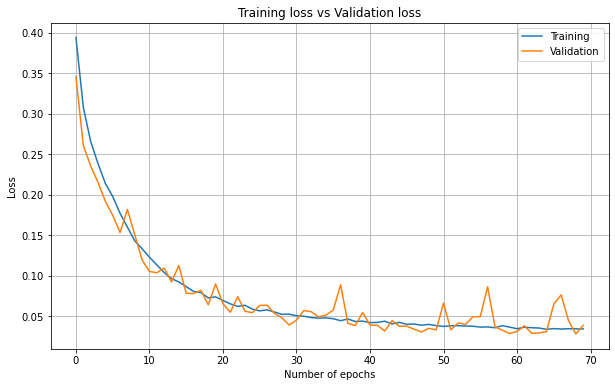

In [16]:
[loss, mae] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = standardScaler.inverse_transform(y)


train_loss = history.history['loss']


val_loss = history.history['val_loss']


def plot_train_val(A, B, n, xlabel, ylabel, title):
    pltp.figure(1, figsize=(10, 6))
    pltp.plot(range(n),A)
    pltp.plot(range(n),B)
    pltp.ylabel(xlabel)
    pltp.xlabel(ylabel)
    pltp.title(title)
    pltp.grid(True)
    pltp.legend(['Training', 'Validation'])
    pltp.show()


plot_train_val(train_loss, val_loss, 70, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

(543,)
(543,)


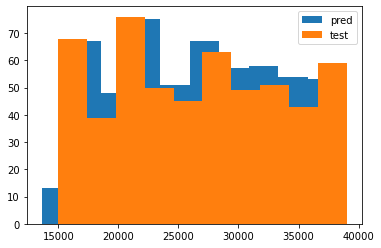

In [17]:
from sklearn.metrics import mean_absolute_error
y_pred_normalized = standardScaler.inverse_transform(pred)
print(y_pred_normalized[:,0].shape)
y_test_normalized = standardScaler.inverse_transform(y_test)
print(y_test_normalized[:,0].shape)
pltp.figure()
pltp.hist(y_pred_normalized[:,0], label="pred")
pltp.hist(y_test_normalized[:,0], label="test")

pltp.legend(loc="best")
pltp.show()

In [18]:
pred[:,0].shape

(543,)

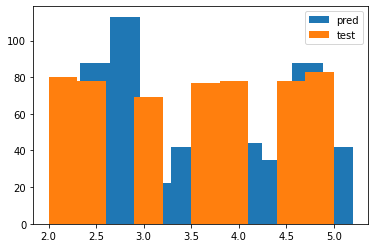

In [19]:
pltp.figure()
pltp.hist(y_pred_normalized[:,1], label="pred")
pltp.hist(y_test_normalized[:,1], label="test")

pltp.legend(loc="best")
pltp.show()

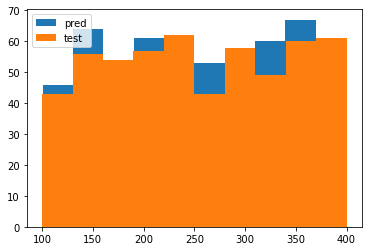

In [20]:
pltp.figure()
pltp.hist(y_pred_normalized[:,2], label="pred")
pltp.hist(y_test_normalized[:,2], label="test")

pltp.legend(loc="best")
pltp.show()

In [21]:
mean_absolute_error(y_pred_normalized, y_test_normalized)

271.9381309438147

In [22]:
model_conv1D.save('../abs_error_35_04.h5')

In [23]:
#read besos
df = pd.read_csv("../data-lineas-espectrales/BESOS/2_Be_stars/HD37041/hd37041_2014-01-29_03-58-58_final_corr.txt", sep="\t", header=None)

m1 = df[0] >= 4460
m2 = df[0] <= 4480

df2 = df[m1][m2]

df2

/var/folders/w9/gh780vs52dgb_ypr6vd5g_4m0000gn/T/ipykernel_5235/942857022.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[m1][m2]


,0,1
2367,4460.022618,0.979893
2368,4460.111978,0.998823
2369,4460.201338,1.020981
2370,4460.290697,1.021009
2371,4460.380057,1.018809
...,...,...
2586,4479.592386,0.986350
2587,4479.681746,0.977661
2588,4479.771106,0.998069
2589,4479.860465,0.996876


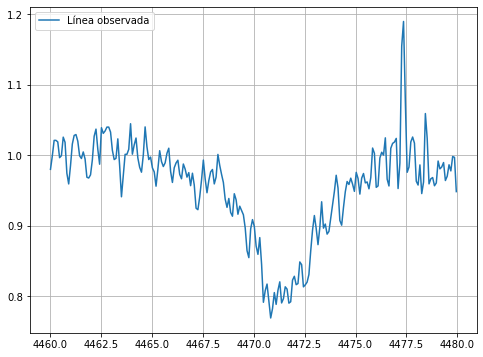

In [24]:
pltp.figure(figsize=(8,6))
pltp.plot(df2[0], df2[1], label="Línea observada")
#plt.plot(df4[0], df4[1], label="Modelo")
pltp.grid()
pltp.legend(loc="best")
pltp.show()

In [25]:
n = 201  # for 2 random indices
index = np.random.choice(df2[0].shape[0], n, replace=False) 
index.sort()

In [26]:
obs_waves = df2[0].values[index]

obs_flux = df2[1].values[index]
obs_flux.shape

(201,)

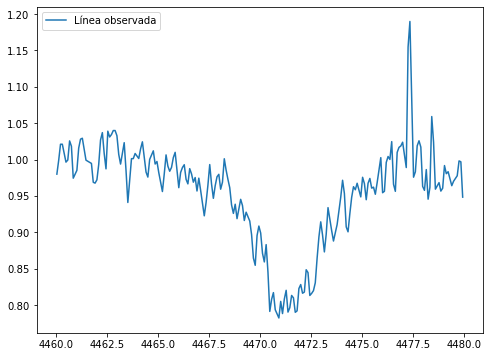

In [27]:
pltp.figure(figsize=(8,6))
pltp.plot(obs_waves, obs_flux ,label="Línea observada")
pltp.legend(loc="best")
pltp.show()

In [28]:
time_steps = 201
input_dimension = 1
obs_flux_reshaped = obs_flux.reshape((1, time_steps, input_dimension))

In [29]:
new_model = tf.keras.models.load_model('../abs_error_35_04.h5')

In [30]:
pred_obs = new_model.predict(obs_flux_reshaped)

In [31]:
print("t_eff:", pred_obs[0][0])
print("log g:", pred_obs[0][1])
print("v_rot:", pred_obs[0][2])

t_eff: 0.25343543
log g: 1.22284
v_rot: -1.0167102


In [32]:
pred_obs_inv = standardScaler.inverse_transform(pred_obs)
print(pred_obs_inv[0,0])
print(pred_obs_inv[0,1])
print(pred_obs_inv[0,2])

28827.549
4.72284
159.06268
